In [12]:
import keras
import numpy as np
from neuralStellar2 import stellarGrid,NNmodel
import pymc3 as pm
import theano.tensor as T
import corner
import pandas as pd
import theano
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('grid2_trun.csv')

In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'])
m1.loadModel('Ran_files/big_grid_73/000_best_model.h5')

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                 20        
_________________________________________________________________
dense_27 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 128)             

RGB star: <br>
1.2 Msun, 4.6 Gyr, [Fe/H]=0, Yinit=0.28, alpha_MLT=1.9 <br>
2.180411 Rsun, 5.049346 Lsun, Teff=5863.663156, delu=49.426916

In [10]:
M=np.array([0.8,1.0,1.2])
Age=np.array([8,6,4])
Feh=np.array([-0.1,0,0.1])
Y=np.array([0.26,0.28,0.30])
MLT=np.array([1.9,1.9,1.9])
print('R/Rsun', 'Teff', 'delta nu', '=')
y_out = 10**m1.model.predict(np.log10([M,Age,10**Feh,Y,MLT]).T).T
y_out[1] = y_out[1]*5000
[obsR, obsTeff, obsDelnu] = y_out
print(y_out)
obsL = (y_out[0])**2*(y_out[1]/5942.261537)**4
print('L/Lsun = '+str(obsL))
#1, 5777, 135

R/Rsun Teff delta nu =
[[7.7952373e-01 1.1601912e+00 7.4298873e+00]
 [5.2430200e+03 5.9457202e+03 5.0319604e+03]
 [1.8394612e+02 1.1365704e+02 8.0444193e+00]]
L/Lsun = [ 0.36827952  1.3491797  28.386135  ]


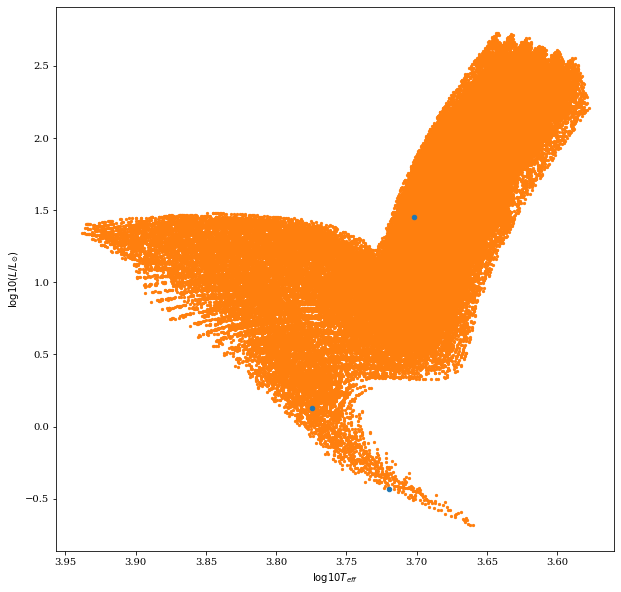

In [20]:
points = df[:100000]
fig, ax=plt.subplots(1,1, figsize=(10,10))
ax.scatter(np.log10(obsTeff), np.log10(obsL), s=20, zorder=10)
ax.scatter(np.log10(points['effective_T']),np.log10(points['luminosity']),s=5,zorder=1)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
plt.show()

Inputs:
M=N(1,0.1)<br>
Age=N(4.5,0.5)<br>
feh=N(0,0.1)<br>
MLT=N(1.9,0.1)<br>
<br>
Outputs(obs):<br>
L=N(1,0.1)<br>
Teff=N(5777,70)<br>
delnu=N(135,15)<br>

In [21]:
model = pm.Model()
with model:
    M1 = pm.Deterministic('mass1',pm.Beta('a1',1.5,1.5)*(2*0.2)+(0.8-0.2))
    Age1 = pm.Deterministic('age1',pm.Beta('b1',1.5,1.5)*(2*0.5)+(8-0.5))
    feh1 = pm.Deterministic('feh1',pm.Beta('c1',1.1,1.1)*(2*0.1)+(-0.1-0.1))
    Y1 = pm.Deterministic('Y1',pm.Beta('d1',1.1,1.1)*(2*0.03)+(0.26-0.03))
    #MLT1 = pm.Deterministic('MLT1',pm.Beta('e1',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    M2 = pm.Deterministic('mass2',pm.Beta('a2',1.5,1.5)*(2*0.2)+(1.0-0.2))
    Age2 = pm.Deterministic('age2',pm.Beta('b2',1.5,1.5)*(2*0.5)+(6-0.5))
    feh2 = pm.Deterministic('feh2',pm.Beta('c2',1.1,1.1)*(2*0.1)+(0-0.1))
    Y2 = pm.Deterministic('Y2',pm.Beta('d2',1.1,1.1)*(2*0.03)+(0.28-0.03))
    #MLT2 = pm.Deterministic('MLT2',pm.Beta('e2',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    M3 = pm.Deterministic('mass3',pm.Beta('a3',1.5,1.5)*(2*0.2)+(1.2-0.2))
    Age3 = pm.Deterministic('age3',pm.Beta('b3',1.5,1.5)*(2*0.5)+(4-0.5))
    feh3 = pm.Deterministic('feh3',pm.Beta('c3',1.1,1.1)*(2*0.1)+(0.1-0.1))
    Y3 = pm.Deterministic('Y3',pm.Beta('d3',1.1,1.1)*(2*0.03)+(0.30-0.03))
    #MLT3 = pm.Deterministic('MLT3',pm.Beta('e3',1.1,1.1)*(2*0.1)+(1.9-0.1))
    
    M = T.stack(M1,M2,M3)
    Age = T.stack(Age1,Age2,Age3)
    feh = T.stack(feh1,feh2,feh3)
    Y = T.stack(Y1,Y2,Y3)
    MLT = T.stack(1.9,1.9,1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    #obs data from NN generated
    obs_L = pm.Normal('obs_L',(10**obs[0])**2*(10**obs[1]*5000/5942.261537)**4,0.1, observed=obsL)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1]*5000,70, observed=obsTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=obsDelnu)

In [22]:
#start = {'mass': 0.8, 'age': 2.5, 'feh':0.1, 'MLT':1.8}
start = {'mass1': 0.8, 'mass2':1.0, 'mass3':1.2, 'age1': 4.6, 'age2': 4.6, 'age3': 4.6}
with model:
    trace = pm.sample(1000, tune=5000, target_accept = 0.99, start=start, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d3, c3, b3, a3, d2, c2, b2, a2, d1, c1, b1, a1]


ValueError: Not enough samples to build a trace.

In [6]:
pm.summary(trace, var_names=['mass1','age1','mass2','age2','mass3','age3'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass1,0.999,0.000,0.998,1.000,0.000,0.000,72.0,72.0,79.0,159.0,1.01
age1,4.612,0.005,4.601,4.620,0.001,0.000,72.0,72.0,81.0,170.0,1.02
mass2,1.010,0.000,1.009,1.010,0.000,0.000,239.0,239.0,264.0,424.0,1.00
age2,5.098,0.002,5.095,5.100,0.000,0.000,224.0,224.0,223.0,385.0,1.00
mass3,1.205,0.003,1.198,1.209,0.000,0.000,47.0,47.0,70.0,95.0,1.04
age3,4.756,0.037,4.705,4.841,0.005,0.004,47.0,47.0,70.0,95.0,1.04


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022EDE57F668>,
      dtype=object)

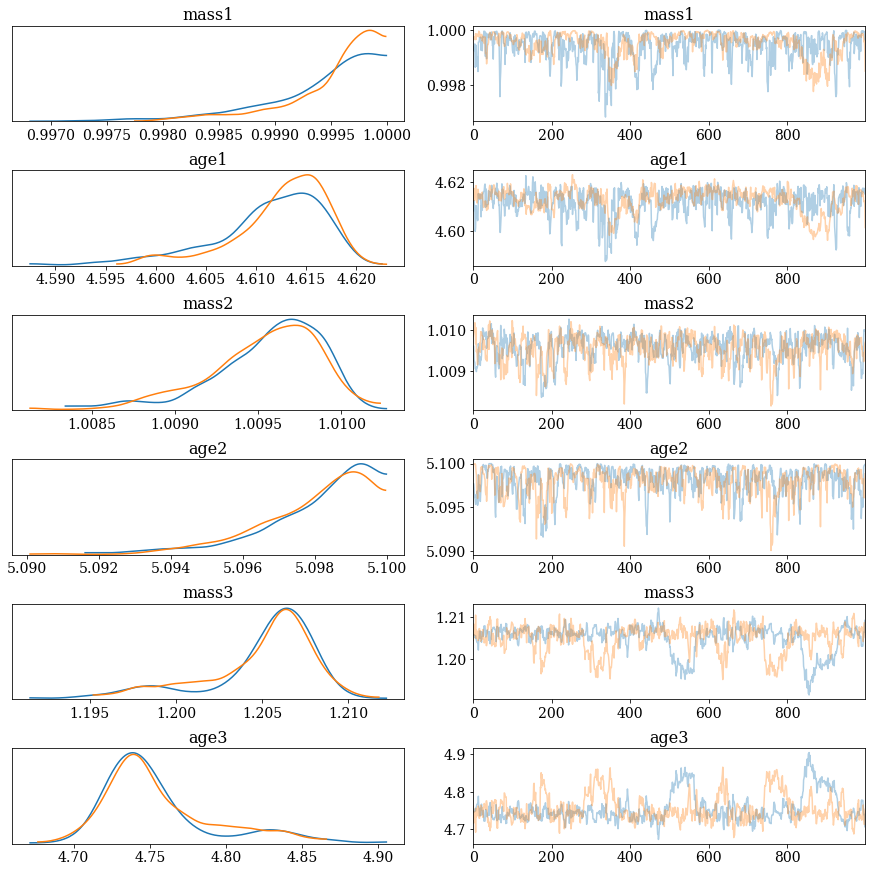

In [7]:
pm.plots.traceplot(trace, var_names=['mass1','age1','mass2','age2','mass3','age3'])

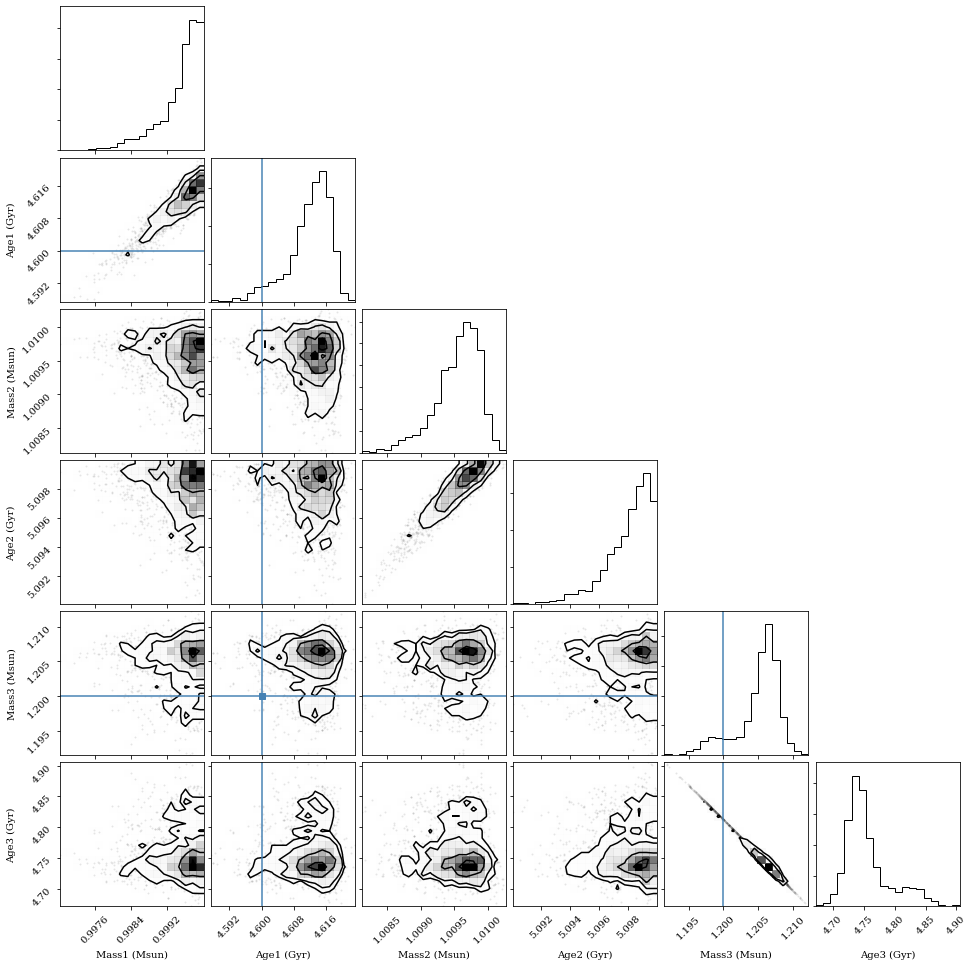

In [9]:
#corner.corner(np.array([trace['mass'], trace['age'], trace['feh'], trace['MLT']]).T, truths=[1.0, 4.5, 0, 1.9],
#             labels=['Mass', 'Age', 'Fe/H', 'Alpha_MLT']);
corner.corner(np.array([trace['mass1'], trace['age1'], trace['mass2'], trace['age2'], trace['mass3'], trace['age3']]).T, 
              truths=[0.8,4.6,1.0,4.6,1.2,4.6], 
              labels=['Mass1 (Msun)','Age1 (Gyr)','Mass2 (Msun)','Age2 (Gyr)','Mass3 (Msun)','Age3 (Gyr)',]);

In [80]:
true_M=1
true_age = 4.577450829
print('error (dex) on mass = ',abs((np.mean(trace['mass'])-true_M)/true_M))
print('error (dex) on age = ',abs((np.mean(trace['age'])-true_age)/true_age))

error (dex) on mass =  0.0013274694638958362
error (dex) on age =  0.016569595239434357


In [4]:
T.ones(5).eval()

array([1., 1., 1., 1., 1.])

In [12]:
grid1 = pd.read_csv('grid2_trun.csv')
grid1 = grid1[grid1['initial_feh']==0]

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,effective_T,luminosity,radius,star_feh,delta_nu,nu_max,tenfeh,tenstarfeh
0,3300910,2,1.28,0.30,0.0,1.7,1.260435,3.662295,4164.398110,118.256239,20.920227,1.376922e-02,1.722789,10.515367,1.0,1.032213
13,7866165,2,1.76,0.30,0.0,2.1,1.753560,1.226000,4723.251740,90.496281,14.226302,1.027665e-02,3.559745,29.704955,1.0,1.023945
15,4936982,2,1.48,0.30,0.0,1.7,1.476795,2.113251,4801.731744,15.323097,5.664171,1.029131e-02,12.933392,156.516994,1.0,1.023980
23,6218481,2,1.64,0.28,0.0,1.9,1.634233,1.762542,4670.197840,50.941674,10.917542,1.178606e-02,5.095554,47.272593,1.0,1.027510
26,3782324,2,1.32,0.28,0.0,2.1,1.313855,3.700863,4835.011599,28.579624,7.629429,1.429926e-02,7.808458,76.485203,1.0,1.033473
33,8643483,2,1.88,0.30,0.0,1.9,1.868154,1.004764,4394.333325,182.351517,23.330687,9.894822e-03,1.769534,12.198995,1.0,1.023045
36,1863702,2,1.08,0.30,0.0,1.9,1.063457,6.664205,4401.491645,67.658969,14.165169,1.529846e-02,2.816597,18.823022,1.0,1.035854
40,9578274,2,1.96,0.26,0.0,2.3,1.958622,1.065937,5199.911572,21.906704,5.775046,6.053234e-03,14.453584,191.891044,1.0,1.014036
42,5141099,2,1.40,0.28,0.0,1.7,1.396953,2.884295,4838.938038,8.714488,4.206100,6.809317e-03,19.668354,267.460949,1.0,1.015803
44,6516993,2,1.68,0.26,0.0,1.9,1.676983,1.802655,4862.294883,21.843439,6.595333,1.136146e-02,10.954879,130.270913,1.0,1.026506


In [18]:
grid1 = grid1[grid1['initial_Yinit']==0.28]
grid1 = grid1[grid1['initial_mass']==1]
grid1 = grid1[grid1['initial_MLT']==1.9]
grid1 = grid1[grid1['star_age'].between(4.5,4.7)]

In [19]:
grid1

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_mass,star_age,effective_T,luminosity,radius,star_feh,delta_nu,nu_max,tenfeh,tenstarfeh
149233,2027292,1,1.0,0.28,0.0,1.9,1.0,4.574027,5942.261537,1.301724,1.077990,1.590387e-09,126.379732,2630.312959,1.0,1.0
356986,2027293,1,1.0,0.28,0.0,1.9,1.0,4.664695,5943.618183,1.313908,1.082529,1.590890e-09,125.608554,2608.005092,1.0,1.0


In [ ]:
    obs_L = pm.Normal('obs_L',(10**obs[0])**2*(10**obs[1]*5000/5942.261537)**4,0.1, observed=1.301724)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1]*5000,70, observed=5942.261537)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=126.379732)